# Wishart distribution tests
    
See https://github.com/scipy/scipy/blob/master/scipy/stats/_multivariate.py

Note: The mean of the Wishart distribution $W_p(\Sigma, \nu)$
is $\nu \Sigma$, not $\Sigma$ as stated in eq. (17) of TJK13.

In [4]:
import scipy.stats._multivariate as mv

## The following is an alternative definition of a Wishart random variable.

In [5]:
W = mv.wishart_gen()

In [6]:
df = 3; scale = [[1,0], [0,2]];
df

3

In [7]:
W.rvs(df, scale)

array([[ 3.96095812,  0.90252688],
       [ 0.90252688,  2.23097071]])

## Main program.

In [10]:
n_D = 10

In [11]:
sig2 = 5

In [12]:
cov     = np.diag([sig2 for i in range(n_D)])
cov_inv = np.diag([1/sig2 for i in range(n_D)])

In [215]:
a_n_S = []
a_trN_est = []
a_trN_m1_est = []
a_trN_m1_est2 = []

for n_S in range(n_D+5, 50, 1):
    W = mv.wishart(df=n_S-1, scale=cov)
    
    # The mean of a Wishart distribution in 1D is nu. Therefore,
    # we need to divide by nu=n_S-1 (?)
    cov_est = W.rvs() / (n_S-1)
    
    ## Covariance matrix
    
    # The division by n_D is to get the normalised trace.
    trN_est = np.trace(cov_est) / n_D
            
    ## Precision matrix 1: numerically invert covariance
    cov_est_inv = np.linalg.inv(cov_est)
    trN_m1_est = np.trace(cov_est_inv) / n_D
        
    ## Precision matrix 2: sample from inverse Wishart distribution
    Wm1 = mv.invwishart(df=n_S-1, scale=cov_inv)
    cov_est_inv2 = Wm1.rvs()
    trN_m1_est2 = np.trace(cov_est_inv2) * n_S / n_D
    
    # The bias of the inverse is 1/alpha. In other words, multiply with alpha
    # for unbiased estimate
    alpha = (n_S - n_D - 2) / (n_S - 1)
    #print(n_S, trN_est, sig2, '   ', trN_m1_est, trN_m1_est2, 1 / alpha / sig2, 1/sig2)
    
    a_n_S.append(n_S)
    a_trN_est.append(trN_est)
    a_trN_m1_est.append(trN_m1_est)
    a_trN_m1_est2.append(trN_m1_est2)

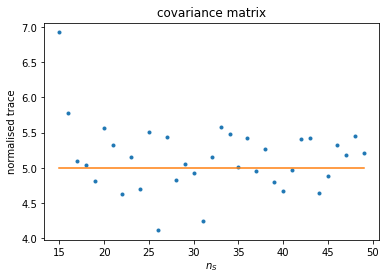

In [216]:
plt.plot(a_n_S, a_trN_est, '.', a_n_S, [sig2 for n_S in a_n_S])
plt.xlabel('$n_S$')
plt.ylabel('normalised trace')
plt.title('covariance matrix')
plt.show()

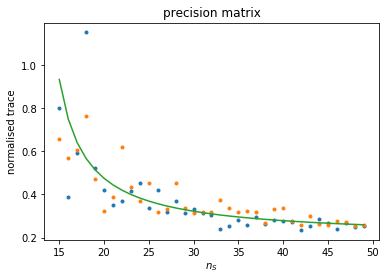

In [217]:
plt.plot(a_n_S, a_trN_m1_est, '.', \
         a_n_S, a_trN_m1_est2, '.', \
         a_n_S, [(n_S - 1) / (n_S - n_D - 2) / sig2 for n_S in a_n_S])
plt.xlabel('$n_S$')
plt.ylabel('normalised trace')
plt.title('precision matrix')
plt.show()

## Plotting the Wishart distribution.

In [312]:
from scipy.stats import multivariate_normal

In [313]:
def get_cov_ML(cov, size):

    n_D = cov.shape[0]
    y2 = multivariate_normal.rvs(mean=np.zeros(n_D), cov=cov, size=size)
    # y2[:,j] = realisations for j-th data entry
    # y2[i,:] = data vector for i-th realisation

    # Calculate covariance matrix via np
    cov_est = np.cov(y2, rowvar=False)
    return cov_est


In [314]:
n_S = 20
n_R = 1000
i=0
j=0
# Correction of scale matrix (true covariance) to match ML cov estimate
cov_c = cov / (n_S - 1)

In [315]:
W = mv.wishart(df=n_S-1, scale=cov_c)
wij = []
for r in range(n_R):
    w = W.rvs()
    wij.append(w[i][j])

In [316]:
cij = []
for r in range(n_R):
    c = get_cov_ML(cov, n_S) 
    cij.append(c[i][j])

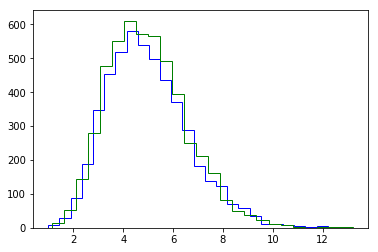

In [317]:
if n_S > n_D:
    plt.hist(wij, bins=25, histtype='step', color='b')
plt.hist(cij, bins=25, histtype='step', color='g')
plt.show()

### Comparing mean and variance

In [319]:
mean_true = cov_c[i][j] * (n_S - 1)
var_true   = (cov_c[i][j]**2 + cov_c[i][i]*cov_c[j][j]) * (n_S - 1)
if n_S > n_D:
    mean_wij  = np.mean(wij)
    var_wij   = np.var(wij)
else:
    mean_wij = 'undef'
    var_wij  = 'undef'
mean_cij  = np.mean(cij)
var_cij   = np.var(cij)
print(mean_true, mean_wij, mean_cij)
print(var_true, var_wij, var_cij)

5.0 4.99740931257 4.98097321472
2.63157894737 2.6646340645 2.52592525284


## Plot of mean and variance as function of n_S

In [343]:
mean_tr = []
var_tr  = []
mean_c  = []
var_c   = []
mean_w  = []
var_w   = []
n_S_arr = []
for n_S in range(3, 100, 5):
    cov_c = cov / (n_S - 1)
    
    cij = []
    for r in range(n_R):
        c = get_cov_ML(cov, n_S) 
        cij.append(c[i][j])
        
    wij = []    
    if n_S > n_D:
        W = mv.wishart(df=n_S-1, scale=cov_c)
        for r in range(n_R):
            w = W.rvs()
            wij.append(w[i][j])
    else:
        wij.append([0, 0])
        
    n_S_arr.append(n_S)
    
    mean_tr.append(cov_c[i][j] * (n_S - 1))
    var_tr.append((cov_c[i][j]**2 + cov_c[i][i]*cov_c[j][j]) * (n_S - 1))
    
    mean_c.append(np.mean(cij))
    var_c.append(np.var(cij))
    
    mean_w.append(np.mean(wij))
    var_w.append(np.var(wij))

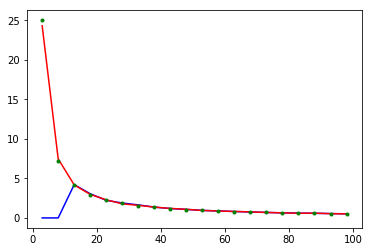

In [344]:
plt.plot(n_S_arr, var_w, 'b', n_S_arr, var_c, 'r', n_S_arr, var_tr, 'g.')
plt.show()